# Pittsburgh Bike Share Ridership Demand Prediction

__Introduction:__

Bike sharing systems have been increasing in demand over the past two decades as a result of rapid advancements in technology. Healthy Ride is a public bicycle sharing system that serves parts of Pittsburgh to fulfill the growing need for changes in mobility pattern. Healthy Ride is operated by Pittsburgh Bike Share and has plans for expansion to reach new neighborhoods by adding more stations, including several electric bikes to help riders navigate Pittsburgh’s hilly geography, located throughout the city. 
In this project, we determine the results of machine learning models such as decision tree, Lasso, Ridge Regression, Random forests, Support-Vector, XG Boosting, Gradient Boosting and Linear Regression. The effect of factors such as weather, geographic location, time of day, day of week. Bike score, Walk-score, distance between stations etc. on the number of bikes at bike-share station are investigated.

__Problem:__

Bike-sharing systems are used world-wide. Given that the system tends to be unbalanced, there are challenging analytical issues such as accurately predicting the demand. This project explores on predicting the total number of bikes rented from individual stations on any given day.

__Clients:__

Bike sharing operators can use this model to proactively shape the mobility market by forecasting demand prediction and to meet customer expectations.




__Project Workflow:__

A project flowchart below shows the order of methods involved in the completion of this project. 


<img src="flowchart.png" style="height:450px">

In [ ]:
#import the necessary libraries
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns
%matplotlib inline

In [470]:
#Load the csv file as pandas Dataframe
df = pd.read_csv("bike_share_rides1.csv", parse_dates = ["start_time","stop_time"])

In [392]:
df.shape

(267260, 28)

In [393]:
df.columns

Index(['trip_id', 'start_time', 'stop_time', 'bike_id', 'trip_duration',
       'from_station_id', 'from_station_name', 'to_station_id', 'station_name',
       'user_type  ', 'from_latitude', 'from_longitude', 'to_latitude',
       'to_longitude', 'TMAX', 'TMIN', 'season', 'holiday', 'walk_score',
       'transit_score', 'bike_score', 'distance', 'event_type', 'rain', 'wind',
       'weather', 'tripdate', 'num_trips_day'],
      dtype='object')

In [394]:
df.head(2)

,trip_id,start_time,stop_time,bike_id,trip_duration,from_station_id,from_station_name,to_station_id,station_name,user_type,...,walk_score,transit_score,bike_score,distance,event_type,rain,wind,weather,tripdate,num_trips_day
0,10676972,2015-05-31 06:54:00,2015-05-31 10:17:00,70166,12190,1018,Butler St & Stanton Ave,1001,Forbes Ave & Market Square,Customer,...,90.0,62.0,75.0,2.67,N,0.37,8.95,2.0,2015-05-31,480
1,10677086,2015-05-31 06:57:00,2015-05-31 09:24:00,70368,8842,1018,Butler St & Stanton Ave,1018,Butler St & Stanton Ave,Subscriber,...,90.0,62.0,75.0,0.00,N,0.37,8.95,2.0,2015-05-31,480


In [395]:
#Variable to hold datetime values:
#trips = df.copy()
i =  pd.to_datetime(df.start_time)
#Transforming columns to split by date, hour or month
df['date'] = i.dt.date
df['hour'] = i.dt.hour
df["month"] = i.dt.month

'The total number of trips made by each user category over the course of the time period from when the program went live on July 1st, 2015  to Dec 31st, 2018 are depicted in this chart'

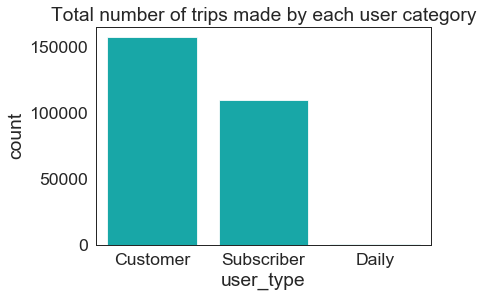

In [396]:

#The total number of trips made by each user category over the course of the time period are depicted in the chart below:
df.columns =df.columns.str.replace(' ', '')    
sns.countplot(x = "user_type", data = df
              , color = "c" ).set_title("Total number of trips made by each user category");
"""The total number of trips made by each user category over the course of the time period from when the program went live on July 1st, 2015  to Dec 31st, 2018 are depicted in this chart"""

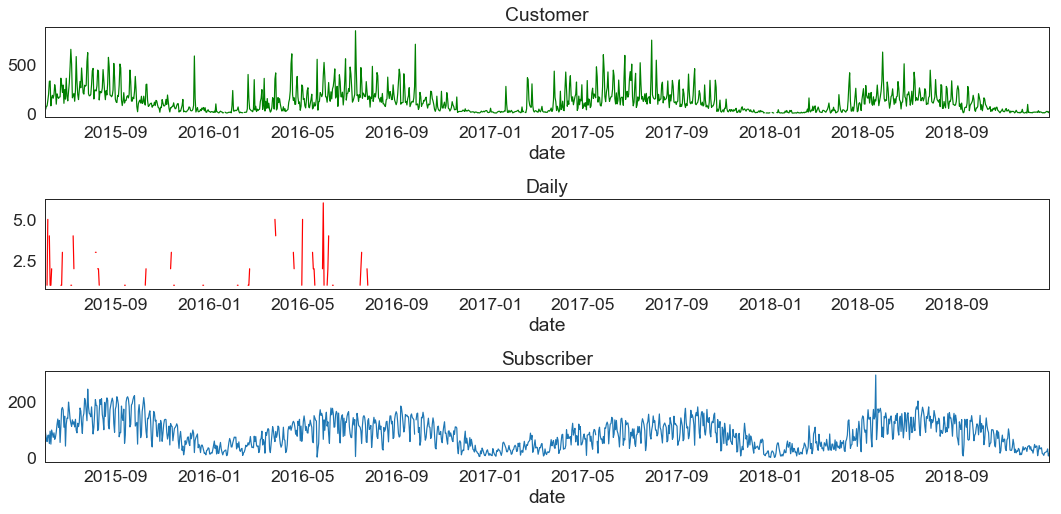

In [397]:
# Count trips by date

by_date = df.pivot_table('trip_id', aggfunc='count', index = "date",columns='user_type' )
fig, ax = plt.subplots(3, figsize=(18, 8))
fig.subplots_adjust(hspace=0.9)
by_date.iloc[:, 0].plot(ax=ax[0],color = "green", title ="Customer");
print("\n")
by_date.iloc[:, 1].plot(ax=ax[1], color = "red",title ="Daily");
by_date.iloc[:, 2].plot(ax=ax[2],title ="Subscriber");


Compared to other user types such as Customer passes and Subscriber passes, Daily pass user type counts looks negligible. There is no corresponding category for daily passes on Healthy ride website as well. It can be concluded from the graph above that the daily passes was issued inconsistently from 2015,Quarter 2 to 2016, Quarter 2. Since there were only 186 instances out of total 267260 rider counts , it will be excluded from further analysis"



In [398]:
df.drop(df.loc[df['user_type']=="Daily"].index, inplace=True)

In [399]:
df.columns

Index(['trip_id', 'start_time', 'stop_time', 'bike_id', 'trip_duration',
       'from_station_id', 'from_station_name', 'to_station_id', 'station_name',
       'user_type', 'from_latitude', 'from_longitude', 'to_latitude',
       'to_longitude', 'TMAX', 'TMIN', 'season', 'holiday', 'walk_score',
       'transit_score', 'bike_score', 'distance', 'event_type', 'rain', 'wind',
       'weather', 'tripdate', 'num_trips_day', 'date', 'hour', 'month'],
      dtype='object')

Text(0.5, 1.0, 'Most popular start stations')

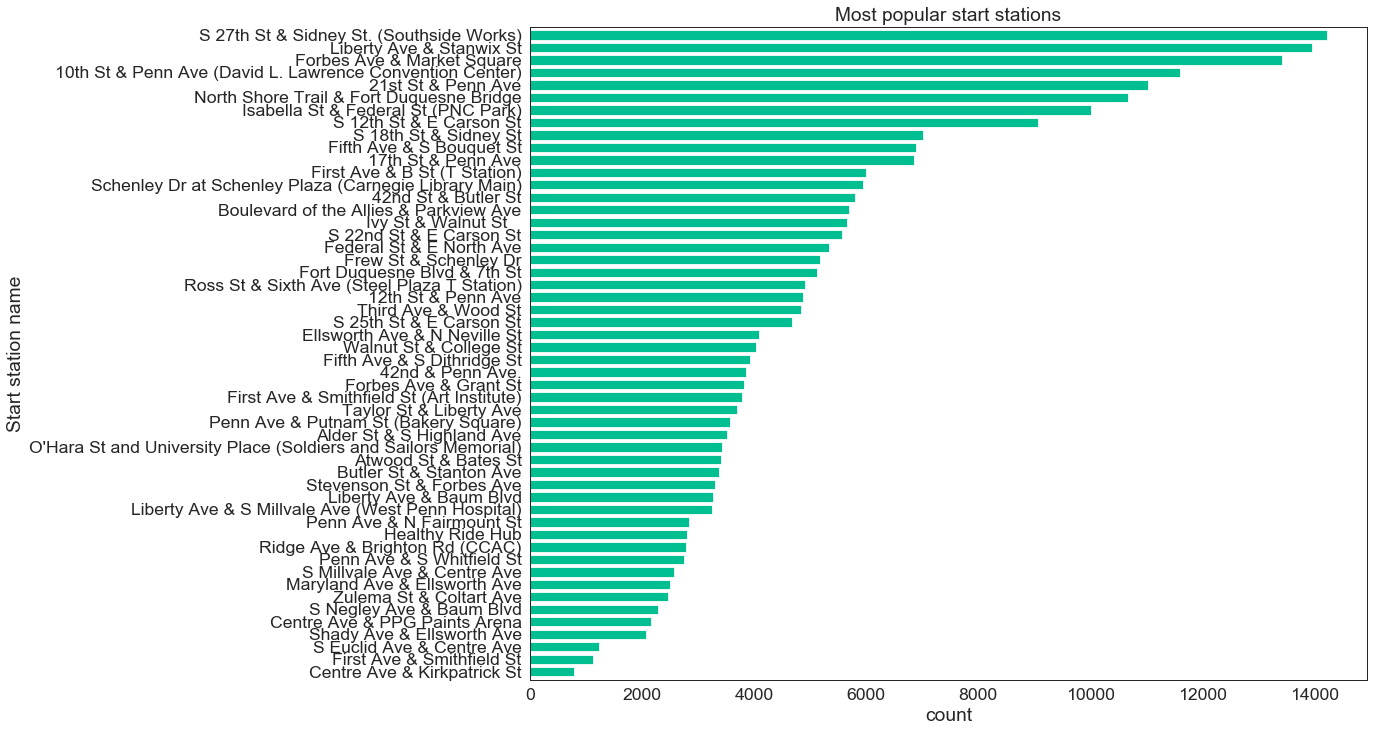

In [400]:
#visualize the popular start stations based on the number of trips taken
x = df['from_station_name'].value_counts().sort_values()
x.plot(kind='barh',figsize=(15, 12), color='#01bf91',  width=0.75);
plt.xlabel("count")
plt.ylabel("Start station name")
plt.title("Most popular start stations")

The plot above is used to visualize the top 15 most popular start stations based on the trip counts. “S 27th St & Sidney St. (Southside Works)” seems to be most popular followed by” Liberty Ave & Stanwix St”, and “Centre Ave & Kirkpatrick St” seems to be the least popular.



In [401]:
# convert trip duration into minutes
df["tr_du_mins"] =df['trip_duration'].div(60)

# converting trip duration into hours
df["tr_du_hr"] = df["tr_du_mins"].div(60)

# to calculate how fast does the rider rides the bike, i will be creating a new column "speed" which calculates the speed in miles per hour
df['speed'] = round(df['distance'] /df['tr_du_hr'], 2)

df['speed'].value_counts()


0.00      70716
0.05        555
0.06        545
0.04        535
0.07        535
0.12        515
0.10        513
0.03        507
0.09        495
0.15        494
0.08        492
0.02        478
0.11        475
0.13        467
0.14        463
0.17        419
0.16        412
5.14        406
0.21        403
0.20        389
0.19        384
0.18        378
0.25        370
5.41        352
0.32        352
0.22        340
0.23        340
0.30        339
0.28        339
4.73        339
          ...  
20.68         1
14.22         1
15.45         1
42.06         1
37.49         1
37.26         1
14.09         1
162.00        1
11.44         1
34.84         1
23.06         1
19.71         1
16.02         1
15.05         1
30.14         1
15.30         1
94.74         1
14.62         1
34.98         1
41.50         1
43.20         1
47.63         1
15.70         1
15.84         1
17.95         1
71.05         1
147.54        1
15.89         1
14.60         1
19.73         1
Name: speed, Length: 181

As we can see,  70716 zero values are recorded where start station and stop station are same and distance is 0.Professional bicycle racers can usually maintain 25-28 mph on flat ground. Let's plot a seaborn regplot to find outliers by plotting speed in miles/hour in y-axis and count in horizontal axis.

Text(0, 0.5, 'speed(mph)')

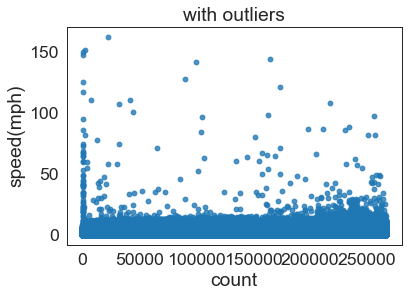

In [402]:
#Since Seaborn doesn't play nice with dates, I'll create a row count column that we can use as our y-axis\n",
df.insert(df.shape[1],'row_count',df.index.value_counts().sort_index().cumsum())
ax = sns.regplot(x=df["row_count"], y=df["speed"], fit_reg=False);
ax.set_title('with outliers')
ax.set_xlabel("count")
ax.set_ylabel('speed(mph)')

In [403]:
df.drop(df.index[df['speed'] == 0], inplace = True)# for data visualization purposes
df.drop(df.index[df['speed'] >= 30], inplace = True)
# Even professional bicycle racers can usually maintain 25-28 mph on flat ground
b.speed.describe()

count    166056.000000
mean          4.483492
std           2.607707
min           0.010000
25%           2.580000
50%           4.560000
75%           6.180000
max          29.880000
Name: speed, dtype: float64

Text(0, 0.5, 'speed(mph)')

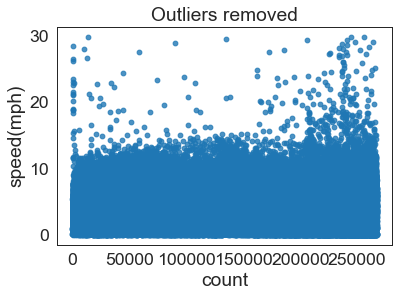

In [404]:
ax =sns.regplot(x=df["row_count"], y=df["speed"], fit_reg=False);
ax.set_title('Outliers removed')
ax.set_xlabel("count")
ax.set_ylabel('speed(mph)')

In [405]:
df.shape

(196230, 35)

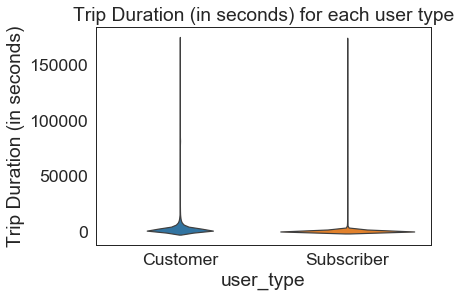

In [406]:
#Generate the violin plot of trip duration in seconds in y-axis and user types in horizontal axis
sns.violinplot(x='user_type', y='trip_duration', data=df, inner = None)
_= plt.title("Trip Duration (in seconds) for each user type")
_=plt.ylabel("Trip Duration (in seconds)")
# Display the plot

The violin plot of trip duration in seconds for each user type has a lot of anomalies. I will generate a box plot of user_type using the trip duration into minutes

In [407]:
#sns.boxplot(x='user_type', y="tr_du_mins", data=df);

Trip duration over 175 minutes do not represent the vast majority of users. According to Healthy Rides website, Customers can take unlimited 15-min trips all day, everyday and if they go over 15-min ride, they will be charged 2 dollars+ tax per 30-mins.  Hence, trips over 175 minutes long will be excluded from further analysis.

In [408]:
df.drop(df.loc[df['tr_du_mins']>= 175].index, inplace=True)

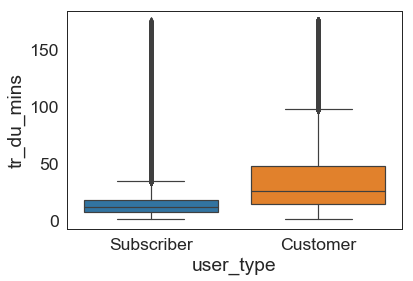

In [409]:
sns.boxplot(x='user_type', y="tr_du_mins", data=df);

In [410]:
df.shape


(189410, 35)

In [411]:
df1 = b.copy()

In [412]:
df1['start_time'] =  pd.to_datetime(df1['start_time'])
df1['weekday'] = df1['start_time'].dt.dayofweek
df1['weekday'].value_counts()

5    27480
4    24599
6    24273
2    23720
1    22501
3    22016
0    21467
Name: weekday, dtype: int64

In [413]:
#trips on work week days (M-F) (including holidays)
df1.groupby('weekday').size().reset_index().rename(columns={'dayweek': 'weekday', 0:'trips'})
len(df1[df1['weekday'] <5])
#trips on weekends (Sa + Su)
#len(df1[df1['weekday'] >=5])
#work week days (M-F) (including holidays)
wh = df1[df1['weekday'] <5]
print('work week days:',len(wh))
holidays = wh[wh.holiday ==1]
print('number of holidays:',len(holidays))
#number of times each day of the week occured 
#0 indicates Monday
weekday_counts = pd.DataFrame({'weekday': [0, 1, 2, 3, 4, 5, 6],
         'days': [52, 52, 52, 52, 52, 52, 53]})
#print('weekday_counts:',weekday_counts)
      
#dataframe of trips by day of week
weekday_trips = df1.groupby('weekday').size().reset_index().rename(columns={'weekday': 'weekday', 0:'trips'})
#weekday_trips
#dataframe of total trips by day of week, number of times each weekday occured 
#and the average number of trips for each day of week
weekday = pd.merge(weekday_trips, weekday_counts, on = 'weekday', how = 'outer')
weekday['average'] = weekday['trips'] / weekday['days']
print("\n")

work week days: 114303
number of holidays: 3788




In [414]:
#creating a new dataframe with a DateTime index that will allow for plotting all trips over time more easily
bf = pd.DataFrame(df1.start_time.value_counts())
#dataframe named bf for bikeframe

bf.index = pd.to_datetime(bf.index)
bf.sort_index(inplace = True)
bf.rename(columns={'starttime':'count'}, inplace = True)
#bf.head()
#this shows number of trips that occured by the second
#designating days of the week as weekends or weekdays to enable analyses that compare the two
weekend = np.where(bf.index.weekday < 5, 'Weekday', 'Weekend')

In [415]:
#Data resampled on an hourly basis 
hourly = bf.resample('H').sum()
hourly.head()
#data for just weekdays (M-F)
hourly_week = bf[weekend == 'Weekday'].resample('H').sum()

#averages for weekday times (including holidays)
hourly_week.groupby(hourly_week.index.hour).sum() / (weekday[:5].sum().days) 
#total sum of trips at each our for weekdays divided by the number of weekdays (M-F) in 2017, giving the average
#data for just weekends (Sa+Su)
hourly_weekend = bf[weekend == 'Weekend'].resample('H').sum()

hourly_weekend.groupby(hourly_weekend.index.hour).sum() / (weekday[5:].sum().days)
#total sum of trips at each our for weekends divided by the number of weekends (Sa+Su) in 2017, giving the average
print('\n')

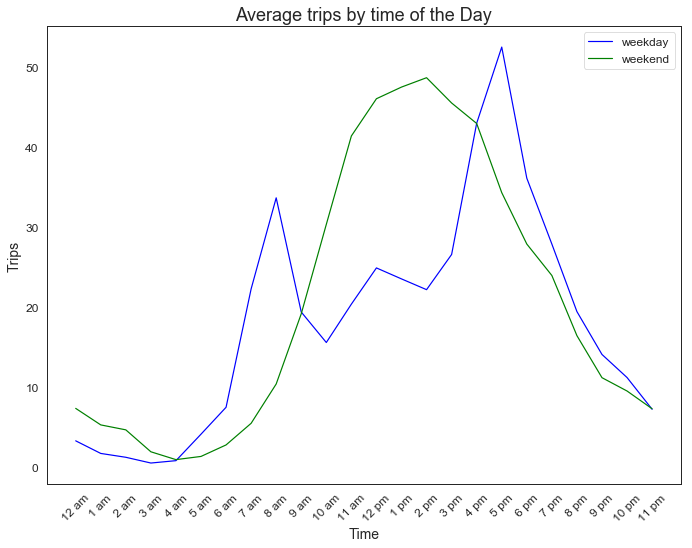

In [416]:
#plot of average trips by hour of day for non-holiday weekdays and weekends together
plt.figure(figsize=(10,8))
#setting data
a = (hourly_week.groupby(hourly_week.index.hour).sum() / ((weekday[:5].sum().days) ))
g = hourly_weekend.groupby(hourly_weekend.index.hour).sum() / weekday[5:].sum().days


#plotting lines
plt.plot(a, 'b')
plt.plot(g, 'g')

plt.legend(['weekday', 'weekend'], fontsize=12)

#axes
plt.xticks(range(0,25), ['12 am', '1 am','2 am', '3 am', '4 am', '5 am', '6 am', '7 am', '8 am', '9 am', '10 am', '11 am','12 pm', '1 pm','2 pm', '3 pm', '4 pm', '5 pm', '6 pm', '7 pm', '8 pm', '9 pm', '10 pm', '11 pm'], fontsize=10)
plt.xticks(rotation=45)
ax.set_xlim(0, 24)
ax.set_ylim(0, 100)

plt.tick_params(axis='both', which='major', labelsize=12)

#labels
plt.title('Average trips by time of the Day', fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Trips', fontsize=14)

plt.tight_layout()


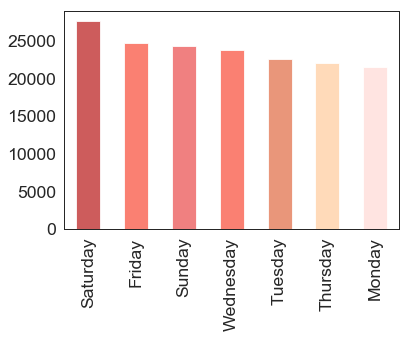

In [417]:
b["start_time"]=pd.to_datetime(b.start_time)
b["day_of_the_week"] = b["start_time"].dt.day_name()
h = b["day_of_the_week"].value_counts()

# Setting a color pallette 
my_colors = ["indianred","salmon","lightcoral","salmon","darksalmon","peachpuff","mistyrose"]*5 # <-- this concatenates the list to itself 5 times.\n",

#Display the graph
h.plot(kind = "bar", color= my_colors)
   

In [418]:
b.columns

Index(['trip_id', 'start_time', 'stop_time', 'bike_id', 'trip_duration',
       'from_station_id', 'from_station_name', 'to_station_id', 'station_name',
       'user_type', 'from_latitude', 'from_longitude', 'to_latitude',
       'to_longitude', 'TMAX', 'TMIN', 'season', 'holiday', 'walk_score',
       'transit_score', 'bike_score', 'distance', 'event_type', 'rain', 'wind',
       'weather', 'tripdate', 'num_trips_day', 'date', 'hour', 'month',
       'tr_du_mins', 'tr_du_hr', 'speed', 'row_count', 'day_of_the_week',
       'start_time_hour', 'start_time_day_name', 'year'],
      dtype='object')

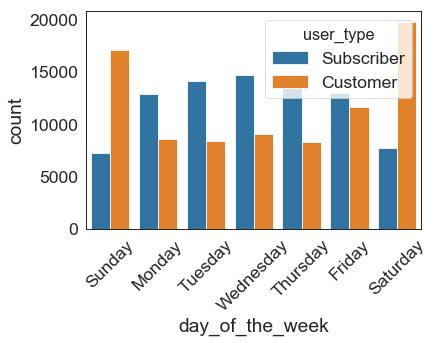

In [419]:
# Rotate the labels so you can read them

plt.xticks(rotation = 45)
sns.countplot(x="day_of_the_week",hue='user_type', data=b);

It is evident from the plot above  that  more customers rent bikes than subscribers on Saturdays and Sundays. It is safe to assume that since Subscribers use bikes more on weekdays than on weekends according to the graph, they might  be renting  bikes  to commute to office.


In [420]:
#Make new dataframe df_rides_day_hour2 to pivot our data and by day and hour, get the count of rides
df['start_time_hour'] = df['start_time'].dt.hour
df['start_time_day_name'] = df['start_time'].dt.weekday_name

df_rides_day_hour2 = pd.pivot_table(b[['start_time_day_name', 'start_time_hour', 'trip_duration']], index=['start_time_day_name', 'start_time_hour'], aggfunc='count')

#Unstack below puts days on the x-axis and hour of day on the y-axis.
df_rides_day_hour3 = df_rides_day_hour2.unstack(level=0)
df_rides_day_hour3.head(2)

trip_duration                                          \
start_time_day_name        Friday Monday Saturday Sunday Thursday Tuesday   
start_time_hour                                                             
0                             220    162      367    406      182     141   
1                             103     80      267    289      113      81   

                               
start_time_day_name Wednesday  
start_time_hour                
0                         154  
1                          72

In [421]:
#Re-index axis so day of week appears in logical progression.
df_rides_day_hour3 = df_rides_day_hour3.reindex(labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1, level=1)

#Create new axis tick labels for easy to read hours and days of the week.
morning_hours = []
for hour in range(1, 12):
    detailed_hour = str(hour) + "am"
    morning_hours.append(detailed_hour)
afternoon_hours = []
for hour in range(1, 12):
    detailed_hour = str(hour) + "pm"
    afternoon_hours.append(detailed_hour)
detailed_hours = ["12am"] + morning_hours + ["12pm"] + afternoon_hours
day_short_names = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']


[Text(40.5, 0.5, 'Starting time (by hour)'),
 Text(0.5, 40.5, 'Day of the Week')]

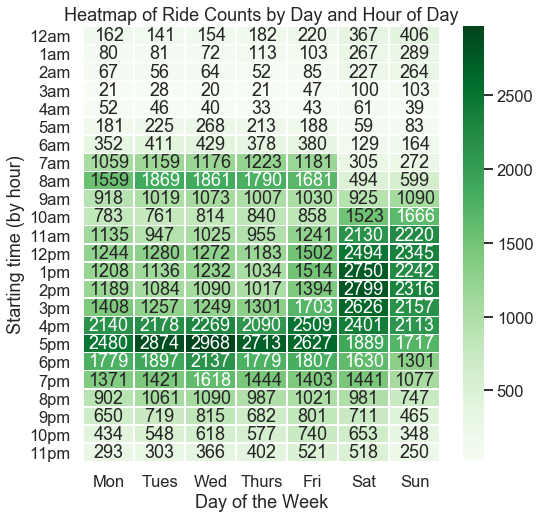

In [422]:
#Plot Heatmap of Ride Counts by Day and Hour of Day
sns.set_context("talk")
f, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(df_rides_day_hour3, annot=True, fmt="d", cmap="Greens",linewidths=.5, ax=ax, xticklabels=day_short_names, yticklabels=detailed_hours)
ax.axes.set_title("Heatmap of Ride Counts by Day and Hour of Day", fontsize=18, y=2.01)
ax.set(xlabel='Day of the Week', ylabel='Starting time (by hour)')

The heat map above shows the total ride counts by hour of the day and Day of the week. On weekdays, Monday to Friday, most rides are taken from 7am to 7pm.On weekends, most rides are taken from 9am - 7pm.


Text(0.5, 1, 'Bike Rentals at Maximum Temperatures by seasons')

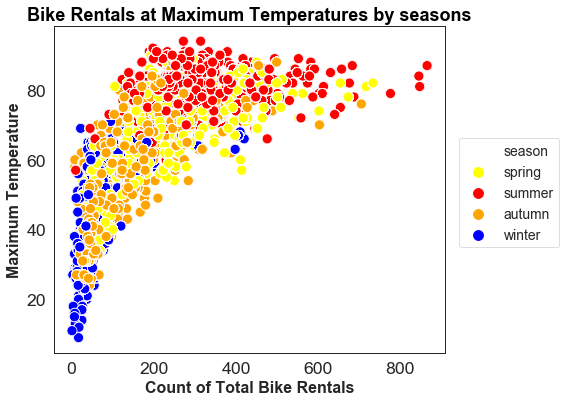

In [423]:
#The plot below depicts the seasonality of bike rentals based on temperatures:
   
plt.figure(figsize=(7,6))
fontdict={'fontsize': 18, 'weight' : 'bold', 'horizontalalignment': 'center'}
sns.set_context('paper', font_scale=2) #this makes the font and scatterpoints much smaller
sns.set_style('white')
sns.scatterplot(y='TMAX', x='num_trips_day', hue = 'season', data= df,  palette=['yellow','red','orange','blue'], legend='full', size='season', sizes=[100,100,100,100])
plt.legend(scatterpoints=1, bbox_to_anchor=(1, 0.7), loc=2, borderaxespad=1., ncol=1, fontsize=14)
plt.ylabel('Maximum Temperature', fontsize=16, fontweight='bold')
plt.xlabel('Count of Total Bike Rentals', fontsize=16, fontweight='bold')
plt.title('Bike Rentals at Maximum Temperatures by seasons', fontdict=fontdict, color="black", position=(0.5,1))

The scatter plot above shows that as the temperature increases the count i.e. the number of total rentals also increases. The maximum number of rental counts seems to be when the temperature is between 60°F to 90°F. There is a clear seasonal trend where the total rental bikes seems to decrease during Winter and increase during summers.

In [424]:
'''0  = Worst weather including all the event types listed in the Storm dataset and WT02
1  = Moderate  weather including the values ( which are not already included in 1) listed in :
                    WT04 - Ice pellets, sleet, snow pellets, or small hail",
                    WT08 - Smoke or haze WT01 - Fog, ice fog, or freezing fog
                    WT03 - Thunder
2 = Good weather not listed in either 1 or 2'''
df['weather'].value_counts()

2.0    186077
1.0      1944
0.0      1389
Name: weather, dtype: int64

In [425]:
# renaming values of the column\n",
df['weather'] = df['weather'].map({0: "worst", 1: "moderate:worst", 2:"good"})
df["weather"].value_counts()

good              186077
moderate:worst      1944
worst               1389
Name: weather, dtype: int64

__Outlier detection:__

Let's remove outliers that deviates drastically from other observations in a dataset which might not necessarily problematic but can skew our model by affecting the slope.

In [426]:
def find_outliers(x):
    #Values below Q1-1.5(Q3-Q1) or above Q3+1.5(Q3-Q1)
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values
indices, values = find_outliers(df['wind'])
print(np.sort(values))

[15.21 15.21 15.21 ... 19.69 19.69 19.69]


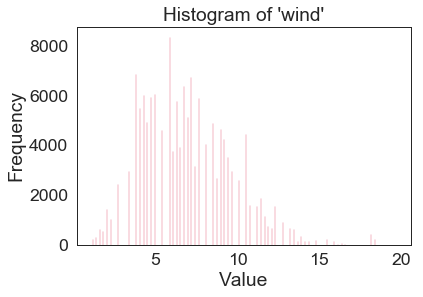

In [427]:
# Use pyplot in matplotlib to plot histograms
%matplotlib inline
import matplotlib.pyplot as plt

def plot_histogram(x):
    n = len(x)
    bins = int(np.sqrt(n))
    plt.hist(x, color='crimson',bins = bins, alpha=0.5)
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()
plot_histogram(df['wind'])

In [428]:
indexNames = df[df['wind']>= 15.2].index
df.drop(indexNames , inplace=True)

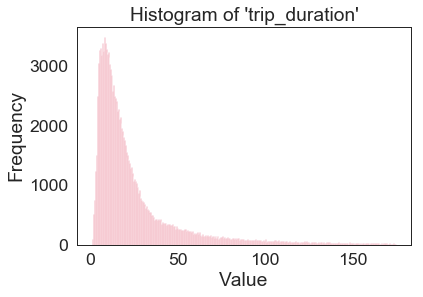

[ 3524  3524  3524 ... 10496 10497 10498]


In [429]:
plot_histogram(df['trip_duration'].div(60))
indices, values = find_outliers(df['trip_duration'])
print(np.sort(values))

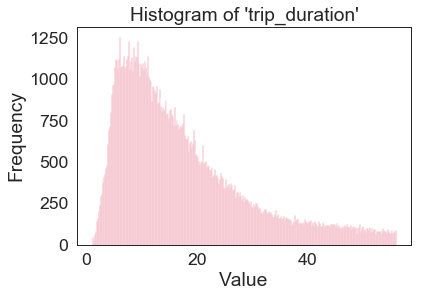

In [430]:
indexNames = df[df['trip_duration']>= 3366].index
df.drop(indexNames , inplace=True)
plot_histogram(df['trip_duration'].div(60))

In [431]:
indices, values = find_outliers(df['distance'])
print(np.sort(values))

[3.27 3.27 3.27 ... 4.97 5.16 5.16]


In [432]:
indexNames = df[df['distance']>= 3.27].index
df.drop(indexNames , inplace=True)

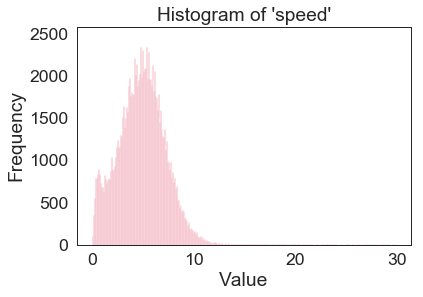

In [433]:
plot_histogram(df['speed'])

In [434]:
indices, values = find_outliers(df['speed'])
print(np.sort(values))

[10.94 10.94 10.94 ... 29.82 29.85 29.88]


In [435]:
indexNames = df[df['speed']>= 10.94].index
df.drop(indexNames , inplace=True)
df.shape

(163317, 37)

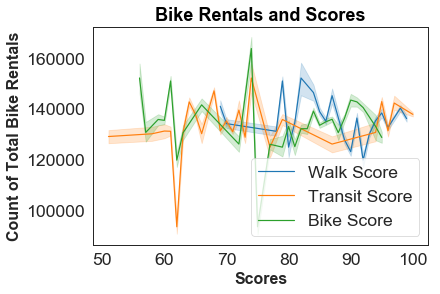

In [436]:
"Let's find outliers in walkscore, bike-score and transit-score columns"
ax = sns.lineplot(x="walk_score", y="row_count", data=df, label = "Walk Score");
ax = sns.lineplot(x="transit_score", y="row_count", data=df, label = "Transit Score");
ax = sns.lineplot(x="bike_score", y="row_count", data=df, label ="Bike Score");
ax.legend()
plt.xlabel('Scores', fontsize=16, fontweight='bold');
plt.ylabel('Count of Total Bike Rentals', fontsize=16, fontweight='bold');
plt.title('Bike Rentals and Scores', fontdict=fontdict, color="black", position=(0.5,1));

As per website , the location with bike score between 70 - 89 is considered as very bikeable. But the graph above shows anomalies at 75 and  the bike rental counts drops drastically.   Hence I will be deleting rows containing bike score of 75, and transit score equal to 61.

In [437]:
df.drop(df.index[df["bike_score"]==75 ],inplace = True)
df.drop(df.index[df["bike_score"]==61 ],inplace = True)

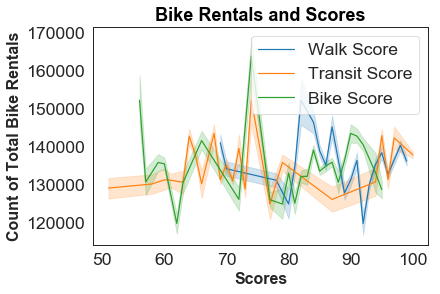

In [438]:
ax = sns.lineplot(x="walk_score", y="row_count", data=df, label = "Walk Score");
ax = sns.lineplot(x="transit_score", y="row_count", data=df, label = "Transit Score");
ax = sns.lineplot(x="bike_score", y="row_count", data=df, label ="Bike Score");
ax.legend()
plt.xlabel('Scores', fontsize=16, fontweight='bold');
plt.ylabel('Count of Total Bike Rentals', fontsize=16, fontweight='bold');
plt.title('Bike Rentals and Scores', fontdict=fontdict, color="black", position=(0.5,1));

In [439]:
df.shape

(157515, 37)

The plot above shows the relation between rental counts and score after removing anomalies. A total of 142666 will be retained for further analysis

In [346]:
#df4 = b.to_csv("Pittsburgh_healthy_bikeshare.csv", index = False)

In [444]:
import os
from folium.plugins import MarkerCluster
import folium

from folium.plugins import HeatMap

remove_bad_values = False
city_name = 'Pittsburgh'
print("Pittsburgh:")
min_lat = df["from_latitude"].min()
print(f"min_lat: {min_lat}")
max_lat = df["from_latitude"].max()
print(f"max_lat: {max_lat}")
min_lon = df["from_longitude"].min()
print(f"min_lon: {min_lon}")
max_lon = df["from_longitude"].max()
print(f"max_lon: {max_lon}")

Pittsburgh:
min_lat: 40.428020000000004
max_lat: 40.470188
min_lon: -80.013204
max_lon: -79.91524799999998


In [445]:
# define centre of map
Pit_COORDINATES = (df['from_latitude'].mean(), df['from_longitude'].mean())
 
  
# create empty map zoomed in on Toronto
map_pit = folium.Map(location=Pit_COORDINATES, zoom_start=12)
df['count'] = 1

# define heat map

HeatMap(data=df[['from_latitude', 'from_longitude', 'count']].groupby(['from_latitude', 'from_longitude']).sum().reset_index().values.tolist(),
        radius=13, max_zoom=15).add_to(map_pit)


display(map_pit)

__Project: Inferential Statistics__

As per [article] (https://www.post-gazette.com/news/transportation/2018/12/02/Healthy-Ride-Pittsburgh-bike-sharing-program-adding-stations-new-neighborhoods/stories/201812020119)  published in  on DEC 3, 2018; there was a noticeable drop in ridership from 2016 to 2017. I would like to to test whether this hypothesis is commensurate with the data.  My consolidated dataset has data from  from 2015, Quarter 2 to 2018, Quarter 4.
The samples are independent of each other and are random. I would be perfoming a two sample, one-tailed upper test  Z test. I would be also be performing a two sample Bootstrap hypothesis test with null hypothesis being that there is no difference in means with regards to the average number of trip counts.

Null Hypothesis:

$ Ho : \mu_{1} = \mu_{2} $ 


Alternate Hypothesis:

$ Ha: \mu_{1} > \mu_{2}  $

Let's also explore the average number of trips taken in each station.

In [449]:
#Segregate the data based on the year
import datetime 
df["year"] = df['start_time'].dt.year

trips_2016, trips_2017 = df[df['year']==2016]['num_trips_day'], df[df['year']==2017]['num_trips_day']

In [450]:
def diff_of_means(data_1,data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) -  np.mean(data_2)

    return diff
empirical_diff_means = diff_of_means(trips_2016, trips_2017)
print(f"Trip_2016 mean : {np.mean(trips_2016)}")

print(f"Trip_2017 mean : {np.mean(trips_2017)}")
print(f"Empirical difference of means: {empirical_diff_means}")


Trip_2016 mean : 290.52376823194595
Trip_2017 mean : 270.64891315286303
Empirical difference of means: 19.87485507908292


The average number of trips of the year 2016 was 290.5237 , and that of year 2017 was 270.64891with a difference of 19.8748. It is possible this observed difference in mean of trip counts was by chance. We will compute the probability of getting at least a 19.8748 difference in average number of trips under the hypothesis that the average number of trip counts in both years are identical.

ECDFs are often even better when doing Exploratory Data Analysis. ECDF is Empirical Cumulative Distribution Function . x- value of ECDF is the quantity you are measuring. The y value(0 to 1 probalibility) is the fraction of datapoints that have a value smaller than the corresponding x value.



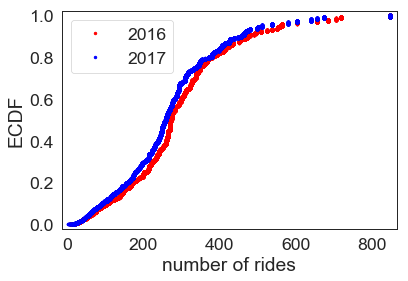

In [451]:
def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1)/float(len(data))


# Create and plot ECDFs from original data
x_1, y_1 = ecdf(trips_2016)
x_2, y_2 = ecdf(trips_2017)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red', label ="2016")
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue',label = "2017")

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('number of rides')
_ = plt.ylabel('ECDF')
_ = plt.legend()
plt.show()


Frequentist Approach:

For our hypothesis to be true, we are going to figure out the probability of getting the actual difference of  means between 2016 and 2017 to be zero under the assumption that our hypothesis is correct. It is going to be a one-tailed upper test. I will set aplha to be 0.05. 
Alpha level is the probability of making te wrong decision when the null hypothesis is true.

Null Hypothesis:

$ Ho : \mu_{1} = \mu_{2} $ 


Alternate Hypothesis:

$ Ha: \mu_{1} > \mu_{2}  $


The Z-test is used to compare the population mean against a sample or compare the population mean of two distributions with a sample size greater than 30. The samples are independent of each other and are random. First, we calculate the z-score to find how many standard deviations away  from $\mu$ as below:

Mean of number of rides per day in 2016($\mu_1$)  = 177.53$

Mean of number of rides per day in 2017($\mu_2$)  = 164.87$

Difference of means between 2016 and 2017 = diff_of_means(trips_2016, trips_2017)

Standard Error(SE) is the standard error of the distribution of differences which is also the standard deviation of that sampling distribution:

SE =  $\sqrt{\frac{\sigma^2_1 }{n_1} + \frac{ \sigma^2_2 }{n_2}}$ 


We can calculate the pooled sample of mean and the standard error (SE) from the sample data. Using those measures, we can compute the z-score test statistic (z).

μo is Hypothesized mean difference which is 0 in this case because according to null hypothesis is there’s no difference.
μo = 0

z-score  = $\frac{(\mu_1 - \mu_2 )- \mu_0}{\sqrt{\frac{\sigma^2_1 }{n_1} + \frac{ \sigma^2_2 }{n_2}}}$

If the Z-score falls in the rejection region, and when the p-value is less than the threshold significance level, which in our case is 5%, we can conclude that the results in difference of means was in fact statistically significant and reject the null hypothesis. Else we fail to reject the null hypothesis.


In [454]:
import scipy
from scipy import stats

#Segregate date based on year
trips_2016, trips_2017 = df[df['year']==2016]['num_trips_day'], df[df['year']==2017]['num_trips_day']


# number of  trips taken  per day in 2016
n_2016 =sum(df[df.year==2016].num_trips_day)
print(f"Total number of trips taken per day in 2016 (n_2016) :{n_2016}")

# number of  trips taken per day in 2017
n_2017 =sum(df[df.year==2017].num_trips_day)
print(f"Total number of rides taken per day in 2017 (n_2017) :{n_2017}")

# number of trips
n1 = len(trips_2016)
print(f"Number of days in trip_2016 data (n1): {n1}")

# number of trips
n2 = len(trips_2017)
print(f"Number of days in  trips_2017 data(n2): {n2}")

"""Alpha level is the probability of making the wrong decision when the null hypothesis is true."""
# Find 95% confidence intervals
crit = stats.norm.isf(0.05)
print(f" Critical value(z-crit) or the boundary of 95% confidence interval of one-tailed upper right test when alpha(rejection region) = 0.05 is +{crit}")
     

#μo which is Hypothesized mean difference is 0 because according to null hypothesis is there’s no difference.
μo = 0

"""SE is the standard error of the distribution of differences which is also the standard deviation of tht sampling distribution"""
SE = np.sqrt((np.std(trips_2016) ** 2/ n1) + (np.std(trips_2017) ** 2/ n2))
print(f"One standard deviation away from 0 would be {SE} SE ")

print(f"Margin of error for interval estimates of difference for these samples is {crit * SE}")

z = ((diff_of_means(trips_2016, trips_2017)) - μo) / SE

print(f"we expect 95% of the sample differences to be in this region: {crit * SE}")
print(f"Z-score  is {z}")

p_val = scipy.stats.norm.sf(abs(z))

if p_val < 0.05:
    print("Since p-value < 0.05, we reject Null Hypothesis")
else:
    print("Accept null hypothesis")

Total number of trips taken per day in 2016 (n_2016) :13066597
Total number of rides taken per day in 2017 (n_2017) :10757753
Number of days in trip_2016 data (n1): 44976
Number of days in  trips_2017 data(n2): 39748
 Critical value(z-crit) or the boundary of 95% confidence interval of one-tailed upper right test when alpha(rejection region) = 0.05 is +1.6448536269514729
One standard deviation away from 0 would be 0.9891311081092545 SE 
Margin of error for interval estimates of difference for these samples is 1.6269758907040368
we expect 95% of the sample differences to be in this region: 1.6269758907040368
Z-score  is 20.093246401959934
Since p-value < 0.05, we reject Null Hypothesis


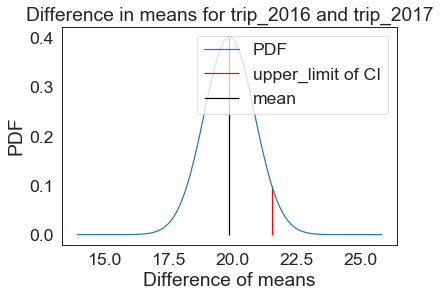

In [457]:
import pylab

# find Margin of error(m)
SE = np.sqrt((np.std(trips_2016) ** 2/ n1) + (np.std(trips_2017) ** 2/ n2))
mu = diff_of_means(trips_2016, trips_2017) 
z = ((diff_of_means(trips_2016, trips_2017)) - 0) / SE
#In an upper tailed Z test, if α =0.05 then the critical value is Z=1.645.
m = 1.645
max_p = mu + m
v = SE * SE
s = SE
x = np.linspace(mu - 6*SE, mu + 6*SE, 100)
y1 = stats.norm.pdf(x, loc=mu, scale=s)    
pylab.plot(x,y1)
pylab.xlabel('Difference of means')
pylab.ylabel('PDF')
pylab.vlines(max_p,0,0.1, color='red')
pylab.vlines(mu,0, .4)
pylab.legend(['PDF', 'upper_limit of CI',"mean" ], loc = "upper right")
pylab.title('Difference in means for trip_2016 and trip_2017')
pylab.show()


The Z-score falls in the rejection region, and the p-value is less than the threshold significance level, which in our case is 5%, we can conclude that the results in difference of means was in fact statistically significant and we can reject the null hypothesis.

__Two-sample bootstrap hypothesis test for difference of means:__
    
We now want to test the hypothesis that the year 2016 and 2017 have the same average trip counts using the two-sample bootstrap test. Here, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. The p-value will be the fraction of replicates with a difference in means greater than or equal to what was observed.

In [458]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

# Concatenate trips: trips_concat
trips_concat = np.concatenate((trips_2016, trips_2017))
# Compute mean of all trips: mean_trips
mean_trips = np.mean(trips_concat)

# Generate shifted arrays
trip_2016_shifted = trips_2016 - np.mean(trips_2016) + mean_trips
trip_2017_shifted = trips_2017 - np.mean(trips_2017) + mean_trips

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_2016 = draw_bs_reps(trip_2016_shifted, np.mean,size= 10000)
bs_replicates_2017 = draw_bs_reps(trip_2017_shifted, np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_2016 - bs_replicates_2017

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)

#Confidence Interval(ci)
ci = np.percentile(bs_replicates, [95])
print(f" Since it is a one tailed test,  there is a 95% chance that the  mean difference estimate by performing bootstrap resampling is : {1-ci}")
print('p-value :', p)
if p < 0.05:
    print("Since p-value is  < 0.05, the difference  is statistically significant and we reject Null Hypothesis with 95 % confidence")
else:
    print("Accept null hypothesis")

 Since it is a one tailed test,  there is a 95% chance that the  mean difference estimate by performing bootstrap resampling is : [-0.61368091]
p-value : 0.0
Since p-value is  < 0.05, the difference  is statistically significant and we reject Null Hypothesis with 95 % confidence


Let's explore average number of bikes rented per day, both overall and for individual stations including the days that were unaccounted for (Zero days). We have to create an empty dataframe based range of dates from the start till end date of the given time period. Then we have to merge after grouping the data as below:

In [463]:
#add a trip date column

df['tripdate'] = df['start_time'].map(lambda x: x.date())
# Create range of dates to use as an index
start = pd.datetime(2015, 5, 31)
end = pd.datetime(2018, 12, 27)
rng = pd.date_range(start, end) 

#Create an empty DataFrame using the range of dates as the index.
trips_by_date_new = pd.DataFrame(index=rng)

#trips_by_date_new.head(2)
# Create a Group by object using tripdate
grp_date = df.groupby('tripdate')


# Compute number of trips by date and check out the result
trips_by_date = pd.DataFrame(grp_date.size(), columns=['num_trips'])


# Merge the two DataFrames on their indexes (tripdate) but do a "left join" with new dataframe on left.
trips_by_date_merged = pd.merge(trips_by_date_new, trips_by_date, how='left', left_index=True, right_index=True, sort=True)


#Replace missing values with zeroes for those dates with no trips
# Fill in any missing values with 0.
trips_by_date_merged['num_trips'] = trips_by_date_merged['num_trips'].fillna(0)

print(trips_by_date_merged.head())

            num_trips
2015-05-31      149.0
2015-06-01       40.0
2015-06-02       61.0
2015-06-03       88.0
2015-06-04      121.0


In [464]:
# Compute the average
mean_trips = trips_by_date_merged['num_trips'].mean()
tot_tripdates = trips_by_date_merged['num_trips'].count() 
num_days = (trips_by_date_merged.index.max() - trips_by_date_merged.index.min()).days + 1

print("The mean number of trips per day is {:.2f} out of  {} tripdates.".format(mean_trips, tot_tripdates))
print(f"Date range is from {trips_by_date.index.min()} : {trips_by_date.index.max()} ")
print("There are {} days in the date range.".format(num_days))

The mean number of trips per day is 120.47 out of  1307 tripdates.
Date range is from 2015-05-31 : 2018-12-30 
There are 1307 days in the date range.



The average number of bikes rented per day overall is ~120 bikes. Now, we will find the average number of bikes per station.

In [466]:
trip["from_station_id"] = trip["from_station_id"].astype(str)

#Average number of rentals per day at individual station including zero days:

stations = trip["from_station_id"].unique()

#add a trip date column
trip['tripdate'] = trip['start_time'].map(lambda x: x.date())

def daily_avg_trips_new(stations, start_date = pd.datetime(2015, 5, 31), end_date = pd.datetime(2018, 12, 27)):
       
    
    for station_id in stations:
        rng = pd.date_range(start_date, end_date)
        trips_by_date_new = pd.DataFrame(index=rng)
        trips_by_date_new['weekday'] = trips_by_date_new.index.map(lambda x: x.weekday())
        grp_date = trip[(trip.from_station_id == station_id)].groupby(['tripdate'])
        # Compute number of trips by date 
        trips_by_date = pd.DataFrame(grp_date.size(), columns=['num_trips'])

        # Step 4: Merge the two DataFrames on their indexes (tripdate) but do a "left join". 
        trips_by_date_merged = pd.merge(trips_by_date_new, trips_by_date, how='left', left_index=True, right_index=True, sort=True)
    
        # Step 5: Replace missing values with zeroes for those dates with no trips
        trips_by_date_merged['num_trips'] = trips_by_date_merged['num_trips'].fillna(0)
    
        # Compute the average
        mean_trips = round(trips_by_date_merged['num_trips'].mean(),2)
        tot_tripdates = trips_by_date_merged['num_trips'].count() 
        num_days = (trips_by_date_merged.index.max() - trips_by_date_merged.index.min()).days + 1
        print(f"The mean number of trips for station_id {station_id}  per day is  {mean_trips}  out of {tot_tripdates} tripdates.")

        #print("The mean number of trips per day is {:.2f} out of  {} tripdates.".format(mean_trips, tot_tripdates))
    print(f"Date range is from {trips_by_date.index.min()} : {trips_by_date.index.max()} ")
    print("There are {} days in the date range.".format(num_days))
    
i = daily_avg_trips_new(stations)


The mean number of trips for station_id 1019  per day is  3.19  out of 1307 tripdates.
The mean number of trips for station_id 1005  per day is  2.36  out of 1307 tripdates.
The mean number of trips for station_id 1010  per day is  6.33  out of 1307 tripdates.
The mean number of trips for station_id 1009  per day is  2.68  out of 1307 tripdates.
The mean number of trips for station_id 1050  per day is  0.95  out of 1307 tripdates.
The mean number of trips for station_id 1000  per day is  5.96  out of 1307 tripdates.
The mean number of trips for station_id 1001  per day is  6.96  out of 1307 tripdates.
The mean number of trips for station_id 1018  per day is  1.94  out of 1307 tripdates.
The mean number of trips for station_id 1002  per day is  2.82  out of 1307 tripdates.
The mean number of trips for station_id 1006  per day is  3.08  out of 1307 tripdates.
The mean number of trips for station_id 1036  per day is  2.79  out of 1307 tripdates.
The mean number of trips for station_id 101

Looks like the average number of rentals per day at individual station including zero days is maximum at station #1001

Text(0, 0.5, 'average number of trips')

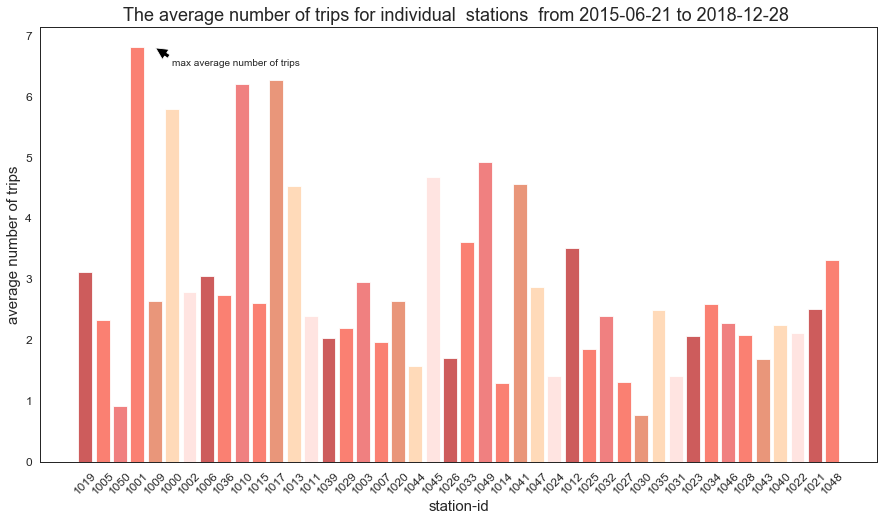

In [468]:
df4 = pd.read_csv("C://avg_num_rentals.csv")
names = [1019, 1005, 1050, 1001, 1009, 1000, 1002, 1006, 1036, 1010, 1015,  1017, 1013, 1011, 1039, 1029, 1003, 1007, 1020, 1044, 1045, 1026,1033, 
         1049, 1014, 1041, 1047, 1024, 1012, 1025, 1032, 1027, 1030, 1035, 1031, 1023, 1034, 1046, 1028, 1043, 1040, 1022, 1021, 1048]

plt.figure(figsize=(15,8))
x = np.arange(len(names))
my_colors = ["indianred","salmon","lightcoral","salmon","darksalmon","peachpuff","mistyrose"]*5 #
plt.bar(x, height= df4["avg_num_rentals"],color = my_colors );
names = [1019, 1005, 1050, 1001, 1009, 1000, 1002, 1006, 1036, 1010, 1015,  1017, 1013, 1011, 1039, 1029, 1003, 1007, 1020, 1044, 1045, 1026,1033, 
         1049, 1014, 1041, 1047, 1024, 1012, 1025, 1032, 1027, 1030, 1035, 1031, 1023, 1034, 1046, 1028, 1043, 1040, 1022, 1021, 1048]
plt.xticks(x, names);
# Setting a color pallette 

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=45)
plt.annotate('max average number of trips', xy=(4, 6.8), xytext=(5, 6.5),  arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('The average number of trips for individual  stations  from 2015-06-21 to 2018-12-28 ', fontsize=18)
plt.xlabel('station-id', fontsize=15)
plt.ylabel('average number of trips', fontsize=15)

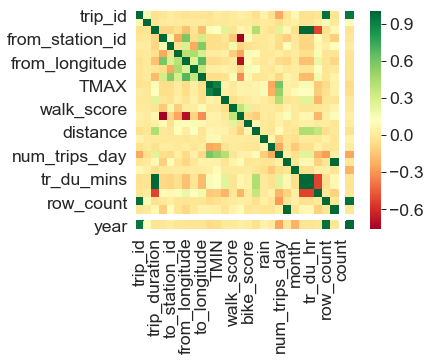

In [469]:
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')